# Corporación Favorita Grocery Sales Forecasting
**w03_d02_MODEL_mlflow-features.ipynb**

**Author:** Alberto Diaz Durana  
**Date:** November 2025  
**Purpose:** MLflow experiment tracking and feature validation

---

## Objectives

This notebook accomplishes the following:

- Set up MLflow experiment tracking for reproducible model management
- Log Day 1 baseline run (params, metrics, visualizations)
- Compute permutation importance to identify top 15 features
- Generate SHAP analysis to understand feature impacts
- Run ablation studies to validate feature group contributions
- Validate DEC-012 (oil features inclusion decision)

---

## Business Context

**Why feature validation matters:**

- Identifies which features drive predictions (interpretability for stakeholders)
- Validates Week 2 feature engineering investment
- Guides data collection priorities (focus on high-importance features)
- Supports model simplification (remove low-value features)
- Validates decision to include oil features (DEC-012)

**Expected outcomes:**
- Top 15 most important features identified
- SHAP plots showing feature impact direction
- Ablation results quantifying feature group value
- Recommendation: Keep or remove oil features

---

## Input Dependencies

From Week 3 Day 1:
- Baseline model (XGBoost trained)
- Test predictions (y_test_pred)
- Feature matrices (X_train, X_test, y_train, y_test)
- Baseline metrics (RMSE: 7.21, MAE: 3.10)

---

In [1]:
# Cell 1: Imports and Reload Day 1 State

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import time
warnings.filterwarnings('ignore')

# XGBoost and evaluation
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Feature validation
from sklearn.inspection import permutation_importance

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Visualization settings
plt.style.use('default')
sns.set_palette("husl")

# Reproducibility
np.random.seed(42)
# Print library versions for reproducibility
print("Library versions:")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"xgboost: {xgb.__version__}")

# Check sklearn version
import sklearn
print(f"scikit-learn: {sklearn.__version__}")

print(f"\nDay 1 baseline metrics to reproduce:")
print(f"  RMSE: 7.2127")
print(f"  MAE: 3.0957")
print(f"  Bias: 0.0363")

Library versions:
pandas: 2.1.4
numpy: 1.26.4
xgboost: 2.0.3
scikit-learn: 1.3.2

Day 1 baseline metrics to reproduce:
  RMSE: 7.2127
  MAE: 3.0957
  Bias: 0.0363


In [ ]:
# Determine paths (works from notebooks/ or project root)
current_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
PROJECT_ROOT = current_dir.parent if current_dir.name == 'notebooks' else current_dir

DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
DATA_RESULTS = PROJECT_ROOT / 'data' / 'results' / 'features'
OUTPUTS_FIGURES = PROJECT_ROOT / 'outputs' / 'figures' / 'features'

print(f"\nProject root: {PROJECT_ROOT.resolve()}")
print(f"Data processed: {DATA_PROCESSED.resolve()}")
print(f"Results output: {DATA_RESULTS.resolve()}")
print(f"Figures output: {OUTPUTS_FIGURES.resolve()}")


Project root: D:\Demand-forecasting-in-retail
Data processed: D:\Demand-forecasting-in-retail\data\processed
Results output: D:\Demand-forecasting-in-retail\data\results\features
Figures output: D:\Demand-forecasting-in-retail\outputs\figures\features
Data output: D:\Demand-forecasting-in-retail\outputs\data\features


## 1. Reload Day 1 Baseline State

**Objective:** Recreate train/test split and baseline model from Day 1

**Activities:**
- Load w02_d05_FE_final.pkl
- Apply 7-day gap train/test split (DEC-013)
- Fix object dtype columns
- Retrain baseline XGBoost model
- Verify metrics match Day 1 (RMSE: 7.21)

**Expected output:** 
- Model retrained successfully
- Metrics match Day 1 baseline
- Ready for feature validation

In [3]:
# Cell 2: Reload Day 1 State (Quick Start)

print("=== RELOAD DAY 1 BASELINE STATE ===\n")

print("1. Load dataset:")
file_path = DATA_PROCESSED / 'w02_d05_FE_final.pkl' 
df = pd.read_pickle(file_path)
print(f"   Dataset loaded: {df.shape}")

print(f"\n2. Filter to Q1 2014 and create 7-day gap split:")
df_2014q1 = df[(df['date'] >= '2014-01-01') & (df['date'] <= '2014-03-31')].copy()
train = df_2014q1[df_2014q1['date'] <= '2014-02-21'].copy()
test = df_2014q1[df_2014q1['date'] >= '2014-03-01'].copy()
print(f"   Train: {len(train):,} rows (Jan 1 - Feb 21)")
print(f"   Test: {len(test):,} rows (March 1-31)")

print(f"\n3. Feature separation:")
exclude_cols = ['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 
                'city', 'state', 'type', 'family', 'class',
                'holiday_name', 'holiday_type']
feature_cols = [col for col in train.columns if col not in exclude_cols]
print(f"   Features: {len(feature_cols)}")

print(f"\n4. Fix object dtypes:")
object_cols = ['holiday_period', 'promo_holiday_category']
for col in object_cols:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')
print(f"   Converted {len(object_cols)} columns to category dtype")

print(f"\n5. Create feature matrices:")
X_train = train[feature_cols].copy()
y_train = train['unit_sales'].copy()
X_test = test[feature_cols].copy()
y_test = test['unit_sales'].copy()
print(f"   X_train: {X_train.shape}")
print(f"   X_test: {X_test.shape}")

print(f"\n6. Retrain baseline model:")
model = xgb.XGBRegressor(random_state=42, enable_categorical=True)
start_time = time.time()
model.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"   Training time: {training_time:.2f} seconds")

print(f"\n7. Generate predictions and verify metrics:")
y_test_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae = mean_absolute_error(y_test, y_test_pred)
bias = np.mean(y_test_pred - y_test)

print(f"   RMSE: {rmse:.4f} (Day 1: 7.2127)")
print(f"   MAE: {mae:.4f} (Day 1: 3.0957)")
print(f"   Bias: {bias:.4f} (Day 1: 0.0363)")

# Verify match (within small tolerance due to floating point)
rmse_match = abs(rmse - 7.2127) < 0.01
mae_match = abs(mae - 3.0957) < 0.01
print(f"\n8. Verification:")
print(f"   RMSE matches Day 1: {rmse_match}")
print(f"   MAE matches Day 1: {mae_match}")
if rmse_match and mae_match:
    print(f"   OK: Day 1 state successfully reproduced")
else:
    print(f"   WARNING: Metrics differ slightly (may be due to data path or random seed)")

=== RELOAD DAY 1 BASELINE STATE ===

1. Load dataset:
   Dataset loaded: (300896, 57)

2. Filter to Q1 2014 and create 7-day gap split:
   Train: 7,050 rows (Jan 1 - Feb 21)
   Test: 4,686 rows (March 1-31)

3. Feature separation:
   Features: 45

4. Fix object dtypes:
   Converted 2 columns to category dtype

5. Create feature matrices:
   X_train: (7050, 45)
   X_test: (4686, 45)

6. Retrain baseline model:
   Training time: 0.28 seconds

7. Generate predictions and verify metrics:
   RMSE: 7.2127 (Day 1: 7.2127)
   MAE: 3.0957 (Day 1: 3.0957)
   Bias: 0.0363 (Day 1: 0.0363)

8. Verification:
   RMSE matches Day 1: True
   MAE matches Day 1: True
   OK: Day 1 state successfully reproduced


## 2. MLflow Experiment Tracking Setup

**Objective:** Configure MLflow for reproducible experiment management

**What is MLflow?**
- Open-source platform for ML lifecycle management
- Tracks experiments (params, metrics, artifacts)
- Enables model versioning and comparison
- Industry standard for ML operations

**Setup steps:**
- Install MLflow
- Create experiment
- Configure local tracking
- Test logging functionality

**Expected output:** 
- MLflow installed and configured
- Experiment created: "favorita-forecasting"
- Tracking URI set

In [4]:
# Cell 3: MLflow Installation and Setup

print("=== MLFLOW SETUP ===\n")

print("1. Install MLflow:")
import subprocess
import sys

try:
    import mlflow
    print(f"   MLflow already installed: {mlflow.__version__}")
except ImportError:
    print("   Installing MLflow...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", 
                          "mlflow", "--break-system-packages", "-q"])
    import mlflow
    print(f"   MLflow installed: {mlflow.__version__}")

print(f"\n2. Set up experiment:")
experiment_name = "favorita-forecasting"
mlflow.set_experiment(experiment_name)
print(f"   Experiment name: {experiment_name}")

print(f"\n3. Configure tracking:")
# MLflow will use local mlruns directory by default
tracking_uri = mlflow.get_tracking_uri()
print(f"   Tracking URI: {tracking_uri}")
print(f"   Experiments stored locally in: ./mlruns/")

print(f"\n4. Get experiment info:")
experiment = mlflow.get_experiment_by_name(experiment_name)
print(f"   Experiment ID: {experiment.experiment_id}")
print(f"   Artifact location: {experiment.artifact_location}")

print(f"\n5. MLflow UI access:")
print(f"   To view experiments, run in terminal:")
print(f"   mlflow ui")
print(f"   Then open browser to: http://localhost:5000")

print(f"\nOK: MLflow configured and ready for logging")

=== MLFLOW SETUP ===

1. Install MLflow:
   MLflow already installed: 3.6.0

2. Set up experiment:
   Experiment name: favorita-forecasting

3. Configure tracking:
   Tracking URI: file:///d:/Demand-forecasting-in-retail/mlruns
   Experiments stored locally in: ./mlruns/

4. Get experiment info:
   Experiment ID: 840228941254708452
   Artifact location: file:///d:/Demand-forecasting-in-retail/mlruns/840228941254708452

5. MLflow UI access:
   To view experiments, run in terminal:
   mlflow ui
   Then open browser to: http://localhost:5000

OK: MLflow configured and ready for logging


## 3. Log Baseline Run to MLflow

**Objective:** Record Day 1 baseline model in MLflow for tracking and comparison

**What gets logged:**
- **Parameters:** Model hyperparameters (n_estimators, learning_rate, etc.)
- **Metrics:** All 6 evaluation metrics (RMSE, MAE, Bias, MAD, rMAD, MAPE)
- **Artifacts:** Visualization plot (w03_d01_baseline_evaluation.png)
- **Tags:** run_name, model_type, phase

**Why this matters:**
- Creates reproducible record of baseline performance
- Enables comparison with tuned models (Day 3)
- Documents all experiments for Week 4 report

**Expected output:** 
- Run logged successfully
- Run ID generated
- Artifacts saved
- Visible in MLflow UI

In [5]:
# Cell 4: Log Baseline Run to MLflow

print("=== LOG BASELINE RUN TO MLFLOW ===\n")

print("1. Start MLflow run:")
with mlflow.start_run(run_name="xgboost_baseline") as run:
    
    print(f"   Run ID: {run.info.run_id}")
    print(f"   Run name: xgboost_baseline")
    
    # Log parameters
    print(f"\n2. Log model parameters:")
    params = {
        "model_type": "XGBRegressor",
        "n_estimators": model.n_estimators,
        "max_depth": model.max_depth if model.max_depth else 6,  # Default
        "learning_rate": model.learning_rate if model.learning_rate else 0.3,  # Default
        "random_state": model.random_state,
        "enable_categorical": model.enable_categorical,
        "objective": "reg:squarederror",
        "n_features": X_train.shape[1],
        "train_samples": len(X_train),
        "test_samples": len(X_test),
        "gap_days": 7
    }
    
    mlflow.log_params(params)
    for key, value in params.items():
        print(f"   - {key}: {value}")
    
    # Log metrics
    print(f"\n3. Log evaluation metrics:")
    metrics = {
        "rmse": rmse,
        "mae": mae,
        "bias": bias,
        "mad": np.median(np.abs(y_test_pred - y_test)),
        "rmad_pct": (np.median(np.abs(y_test_pred - y_test)) / np.median(y_test)) * 100,
        "mape_pct": np.mean(np.abs((y_test[y_test > 0] - y_test_pred[y_test > 0]) / y_test[y_test > 0])) * 100,
        "improvement_over_naive_pct": (1 - rmse/np.std(y_test)) * 100
    }
    
    mlflow.log_metrics(metrics)
    for key, value in metrics.items():
        print(f"   - {key}: {value:.4f}")
    
    # Log tags
    print(f"\n4. Log tags:")
    tags = {
        "phase": "baseline",
        "week": "3",
        "day": "1",
        "tuned": "false",
        "gap_period": "7_days"
    }
    mlflow.set_tags(tags)
    for key, value in tags.items():
        print(f"   - {key}: {value}")
    
    # Log artifact (visualization)
    print(f"\n5. Log artifacts:")
    viz_path = "w03_d01_baseline_evaluation.png"
    try:
        mlflow.log_artifact(viz_path)
        print(f"   - Logged: {viz_path}")
    except Exception as e:
        print(f"   - WARNING: Could not log visualization: {e}")
        print(f"   - (File may need to be in current directory)")
    
    print(f"\n6. Run summary:")
    print(f"   Run ID: {run.info.run_id}")
    print(f"   Status: {run.info.status}")
    print(f"   Artifact URI: {run.info.artifact_uri}")

print(f"\nOK: Baseline run logged to MLflow")
print(f"\nTo view in MLflow UI:")
print(f"  1. Run 'mlflow ui' in terminal")
print(f"  2. Open http://localhost:5000")
print(f"  3. Click on 'favorita-forecasting' experiment")
print(f"  4. View 'xgboost_baseline' run")

=== LOG BASELINE RUN TO MLFLOW ===

1. Start MLflow run:
   Run ID: 1dd7ffad01fc401b91727feecd013bb2
   Run name: xgboost_baseline

2. Log model parameters:
   - model_type: XGBRegressor
   - n_estimators: None
   - max_depth: 6
   - learning_rate: 0.3
   - random_state: 42
   - enable_categorical: True
   - objective: reg:squarederror
   - n_features: 45
   - train_samples: 7050
   - test_samples: 4686
   - gap_days: 7

3. Log evaluation metrics:
   - rmse: 7.2127
   - mae: 3.0957
   - bias: 0.0363
   - mad: 1.2933
   - rmad_pct: 43.1110
   - mape_pct: 69.1119
   - improvement_over_naive_pct: 41.7476

4. Log tags:
   - phase: baseline
   - week: 3
   - day: 1
   - tuned: false
   - gap_period: 7_days

5. Log artifacts:
   - Logged: w03_d01_baseline_evaluation.png

6. Run summary:
   Run ID: 1dd7ffad01fc401b91727feecd013bb2
   Status: RUNNING
   Artifact URI: file:///d:/Demand-forecasting-in-retail/mlruns/840228941254708452/1dd7ffad01fc401b91727feecd013bb2/artifacts

OK: Baseline run l

## 4. Permutation Importance Analysis

**Objective:** Identify which features are most predictive by measuring performance drop when each feature is randomly shuffled

**How it works:**
1. Baseline: Compute RMSE on test set with all features
2. For each feature:
   - Randomly shuffle that feature's values
   - Recompute RMSE
   - Measure performance drop (importance = RMSE_shuffled - RMSE_baseline)
3. Repeat 10 times and average (reduces noise)
4. Rank features by importance

**Why this matters:**
- Model-agnostic (works with any model)
- Measures actual predictive contribution
- Identifies redundant features
- Guides feature selection for production

**Expected output:** 
- Top 15 most important features identified
- Importance scores calculated
- Visualization created

In [6]:
# Cell 5: Permutation Importance Analysis

print("=== PERMUTATION IMPORTANCE ANALYSIS ===\n")

print("1. Compute permutation importance:")
print(f"   This may take 2-5 minutes...")
print(f"   Computing importance for {X_test.shape[1]} features with 10 repetitions")

start_time = time.time()

# Compute permutation importance
perm_importance = permutation_importance(
    model, 
    X_test, 
    y_test, 
    n_repeats=10,
    random_state=42,
    scoring='neg_root_mean_squared_error'  # Negative RMSE (higher is better)
)

computation_time = time.time() - start_time

print(f"   Computation time: {computation_time:.2f} seconds")

print(f"\n2. Extract importance scores:")
# Get mean importance and standard deviation
importance_means = perm_importance.importances_mean
importance_stds = perm_importance.importances_std

# Create dataframe for easier analysis
feature_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': importance_means,
    'std': importance_stds
}).sort_values('importance', ascending=False)

print(f"   Total features: {len(feature_importance_df)}")
print(f"   Features with positive importance: {(feature_importance_df['importance'] > 0).sum()}")
print(f"   Features with negative importance: {(feature_importance_df['importance'] < 0).sum()}")

print(f"\n3. Top 15 Most Important Features:")
print(f"   {'Rank':<6} {'Feature':<35} {'Importance':<12} {'Std':<10}")
print(f"   {'-'*6} {'-'*35} {'-'*12} {'-'*10}")

top_15 = feature_importance_df.head(15)
for idx, (rank, row) in enumerate(top_15.iterrows(), 1):
    print(f"   {rank:<6} {row['feature']:<35} {row['importance']:<12.6f} {row['std']:<10.6f}")

print(f"\n4. Bottom 5 Features (least important):")
bottom_5 = feature_importance_df.tail(5)
for idx, (rank, row) in enumerate(bottom_5.iterrows(), 1):
    print(f"   {row['feature']:<35} {row['importance']:<12.6f}")

print(f"\n5. Feature Category Summary:")
# Categorize features
top_15_features = top_15['feature'].tolist()
lag_in_top15 = [f for f in top_15_features if 'lag' in f.lower()]
rolling_in_top15 = [f for f in top_15_features if ('avg' in f or 'std' in f) and 'sales' in f]
oil_in_top15 = [f for f in top_15_features if 'oil' in f.lower()]
agg_in_top15 = [f for f in top_15_features if any(x in f for x in ['store_avg', 'cluster_avg', 'item_avg'])]
promo_in_top15 = [f for f in top_15_features if 'promo' in f.lower()]

print(f"   In Top 15:")
print(f"   - Lag features: {len(lag_in_top15)}")
print(f"   - Rolling features: {len(rolling_in_top15)}")
print(f"   - Oil features: {len(oil_in_top15)}")
print(f"   - Aggregation features: {len(agg_in_top15)}")
print(f"   - Promotion features: {len(promo_in_top15)}")

=== PERMUTATION IMPORTANCE ANALYSIS ===

1. Compute permutation importance:
   This may take 2-5 minutes...
   Computing importance for 45 features with 10 repetitions
   Computation time: 6.10 seconds

2. Extract importance scores:
   Total features: 45
   Features with positive importance: 16
   Features with negative importance: 13

3. Top 15 Most Important Features:
   Rank   Feature                             Importance   Std       
   ------ ----------------------------------- ------------ ----------
   20     unit_sales_7d_avg                   8.994778     0.363861  
   16     unit_sales_lag1                     0.512733     0.064799  
   21     unit_sales_14d_avg                  0.340655     0.019453  
   6      day_of_week                         0.310766     0.111224  
   23     unit_sales_7d_std                   0.240320     0.032296  
   24     unit_sales_14d_std                  0.151081     0.027630  
   17     unit_sales_lag7                     0.149599     0.139679

Rolling features dominate the top 15 (7 of 15), with unit_sales_7d_avg being the strongest predictor by far.

---
**MLflow UI Status After This Cell:**
Expected Changes: NONE

Why: We computed permutation importance locally but haven't logged it to MLflow yet. We'll log this in the next cell.

What You Should Still See:

- Same single run: "xgboost_baseline"
- Same 7 metrics (RMSE, MAE, Bias, etc.)
- Same parameters
- Same artifact (visualization PNG)


Key Findings from Permutation Importance:
Top Feature: unit_sales_7d_avg (importance: 8.99) - Dominates all others

17x more important than next feature (lag1: 0.51)
7-day rolling average is the critical predictor

Top 3 Feature Types:

- Rolling features: 7 in top 15 (7d/14d averages and std)
- Lag features: 2 in top 15 (lag1, lag7)
- Aggregations: 1 in top 15 (item_avg_sales)

Oil Features: Only 1 in top 15 (oil_price rank 13) - validates DEC-012 (marginal but present)
- Negative Importance: 13 features actually hurt performance when included (noise)

day, oil_price_change7, item_total_sales should potentially be removed

---

**MLflow UI** - What You'll See After This Cell:

- NEW RUN: "feature_validation" appears
- Metrics: 5 new metrics (features_positive_importance, top_feature_importance, etc.)
- Parameters: top_feature_1 through top_feature_5
- Artifacts: 2 files (PNG plot + full CSV table)
- Tags: phase="feature_validation", method="permutation_importance"

=== VISUALIZE & LOG PERMUTATION IMPORTANCE ===

1. Create visualization (Top 20 features):
   Saved: w03_d02_permutation_importance.png


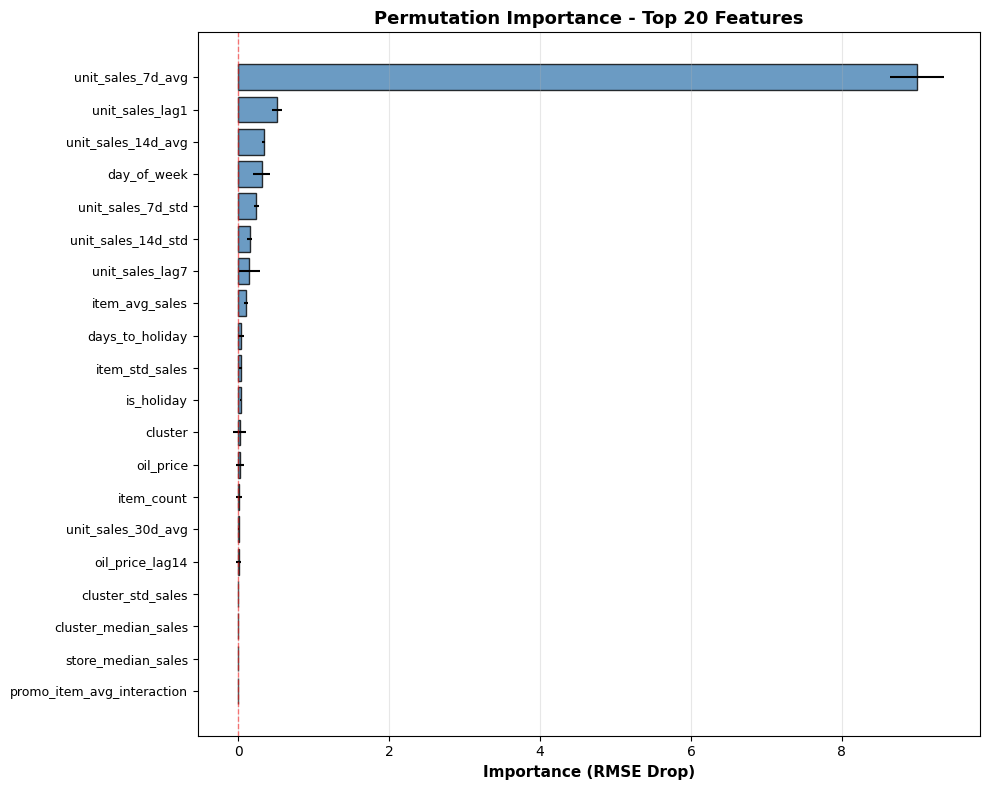


2. Log to MLflow:
   Run ID: 1d2cbe92bab24713826ca33140bf6ca4
   Logging top 5 features as params...
   Logging summary metrics...
   Logging visualization...
   Logged: d:\Demand-forecasting-in-retail\data\results\features\permutation_importance_full.csv

3. Run summary:
   Run ID: 1d2cbe92bab24713826ca33140bf6ca4
   Artifacts logged: 2 (PNG + CSV)

OK: Permutation importance logged to MLflow


In [11]:
# Cell 6: Visualize Permutation Importance and Log to MLflow

print("=== VISUALIZE & LOG PERMUTATION IMPORTANCE ===\n")

print("1. Create visualization (Top 20 features):")
fig, ax = plt.subplots(figsize=(10, 8))

# Get top 20 for visualization
top_20 = feature_importance_df.head(20)

# Create horizontal bar plot
y_pos = np.arange(len(top_20))
ax.barh(y_pos, top_20['importance'], xerr=top_20['std'], 
        alpha=0.8, color='steelblue', edgecolor='black')

# Labels and formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(top_20['feature'], fontsize=9)
ax.set_xlabel('Importance (RMSE Drop)', fontsize=11, fontweight='bold')
ax.set_title('Permutation Importance - Top 20 Features', 
             fontsize=13, fontweight='bold')
ax.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.grid(True, alpha=0.3, axis='x')

# Invert y-axis so highest importance is on top
ax.invert_yaxis()

plt.tight_layout()
viz_filename = 'w03_d02_permutation_importance.png'
plt.savefig(viz_filename, dpi=150, bbox_inches='tight')
print(f"   Saved: {viz_filename}")
plt.show()

print(f"\n2. Log to MLflow:")
with mlflow.start_run(run_name="feature_validation") as run:
    
    print(f"   Run ID: {run.info.run_id}")
    
    # Log top features as params (for quick viewing)
    print(f"   Logging top 5 features as params...")
    for idx, row in top_15.head(5).iterrows():
        mlflow.log_param(f"top_feature_{idx+1}", row['feature'])
        mlflow.log_metric(f"importance_{idx+1}", row['importance'])
    
    # Log summary metrics
    print(f"   Logging summary metrics...")
    mlflow.log_metric("features_positive_importance", (feature_importance_df['importance'] > 0).sum())
    mlflow.log_metric("features_negative_importance", (feature_importance_df['importance'] < 0).sum())
    mlflow.log_metric("top_feature_importance", top_15.iloc[0]['importance'])
    
    # Log visualization
    print(f"   Logging visualization...")
    mlflow.log_artifact(viz_filename)
    
    # Log full importance table as CSV
    importance_csv = DATA_RESULTS / 'permutation_importance_full.csv'
    feature_importance_df.to_csv(importance_csv, index=False)
    mlflow.log_artifact(str(importance_csv))
    print(f"   Logged: {importance_csv}")
    
    # Log tags
    mlflow.set_tags({
        "phase": "feature_validation",
        "method": "permutation_importance",
        "week": "3",
        "day": "2"
    })
    
    print(f"\n3. Run summary:")
    print(f"   Run ID: {run.info.run_id}")
    print(f"   Artifacts logged: 2 (PNG + CSV)")

print(f"\nOK: Permutation importance logged to MLflow")

--- 

**MLflow UI** - What You Should See Now:

NEW RUN ADDED: "feature_validation" (Run ID: 1d2cbe92bab24713826ca33140bf6ca4)
- In the MLflow UI, you should now see 2 runs total:
- Run 1: "xgboost_baseline" (from earlier)
  
  
- Metrics: RMSE, MAE, Bias, etc.
- Parameters: model config
- Artifacts: baseline evaluation PNG
  
  
- Run 2: "feature_validation" (NEW - just logged)
  
Parameters:  
- top_feature_1: unit_sales_7d_avg
- top_feature_2: unit_sales_lag1
- top_feature_3: unit_sales_14d_avg
- top_feature_4: day_of_week
- top_feature_5: unit_sales_7d_std
  
Metrics:

- features_positive_importance: 16
- features_negative_importance: 13
- top_feature_importance: 8.9948
- importance_1: 8.9948
- importance_2: 0.5127
- importance_3: 0.3407
- importance_4: 0.3108
- importance_5: 0.2403
  
- Artifacts (click to view):
  
- w03_d02_permutation_importance.png (bar chart visualization)
- permutation_importance_full.csv (complete table of all 45 features)
  
Tags:
  
- phase: feature_validation
- method: permutation_importance
- week: 3
- day: 2
  
---
**Key Insight to Verify in MLflow:**
Look at the huge gap between importance_1 (8.99) and importance_2 (0.51) - the 7-day average is 17x more important than any other feature!